In [1]:
import pandas as pd
import numpy as np
from time import time
from os import path, makedirs
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
import joblib
from utility import normalize_data, tokenizer, replace, penn_scale, plot_confusion_matrix
import matplotlib.pyplot as plt

In [2]:
## load data
df1 = pd.read_csv('data/S08/question_answer_pairs.txt', sep='\\t', engine='python').dropna()
df2 = pd.read_csv('data/S09/question_answer_pairs.txt', sep='\\t', engine='python').dropna()
df3 = pd.read_csv('data/S10/question_answer_pairs.txt', sep='\\t', engine='python').dropna()
frames = [df1, df2, df3]
df = pd.concat(frames)

questions = df['Question']
answers = df['Answer']

In [3]:
##
## order of appending 'pos' (1) must match the order of appending
##     the 'sent_type' (2) sentence type.
##

## (1) pos: combine questions + answers
questions_pos = questions.apply(tokenizer)
questions_unique = [replace(list(x), penn_scale())  for x in set(tuple(x) for x in questions_pos)]

answers_pos = answers.apply(tokenizer)
answers_unique = [replace(list(x), penn_scale()) for x in set(tuple(x) for x in answers_pos)]

## append data
pos = answers_unique + questions_unique

## (2) sentence type
sent_type = []
for i in range(len(questions_unique)):
    sent_type.append('0')

for j in range(len(answers_unique)):
    sent_type.append('1')

In [4]:
## adjusted dataset
df_adjusted = pd.DataFrame({
    'pos': pos,
    'type': sent_type
})

## train + test
X_train, X_test, y_train, y_test = train_test_split(
    df_adjusted['pos'],
    df_adjusted['type'],
    test_size=0.2
)

## print shape
print('X_train: {X}, y_train: {y}'.format(
    X=X_train.shape,
    y=y_train.shape
))

print('X_test: {X}, y_test: {y}'.format(
    X=X_test.shape,
    y=y_test.shape
))

X_train: (1861,), y_train: (1861,)
X_test: (466,), y_test: (466,)


In [5]:
X_train.head(10)

413     [19, 29, 19, 29, 31, 26, 28, 13, 8, 26, 28]
1361               [37, 8, 14, 7, 15, 32, 9, 7, 15]
916                    [15, 15, 15, 15, 13, 15, 15]
2041             [37, 29, 4, 13, 7, 15, 15, 28, 13]
1249                     [15, 4, 15, 28, 4, 15, 15]
2139                       [37, 33, 15, 31, 26, 15]
375               [27, 14, 32, 26, 4, 8, 13, 7, 14]
1104          [33, 4, 13, 21, 29, 7, 15, 18, 8, 13]
1228                           [35, 33, 33, 31, 31]
2221              [15, 15, 28, 4, 15, 15, 15, 7, 3]
Name: pos, dtype: object

In [6]:
y_train.head(10)

413     0
1361    0
916     0
2041    1
1249    0
2139    1
375     0
1104    0
1228    0
2221    1
Name: type, dtype: object

In [7]:
## normalize datasets
X_train_final = normalize_data(X_train, stop_gap=40, train=True)
X_test_final = normalize_data(X_test, stop_gap=40, train=True)

In [8]:
print(X_train_final.head(10))
print(X_test_final.head(10))

   0   1   2   3   4   5   6   7   8   9  ...  30  31  32  33  34  35  36  37  \
0  19  29  19  29  31  26  28  13   8  26 ...   1   1   1   1   1   1   1   1   
1  37   8  14   7  15  32   9   7  15   1 ...   1   1   1   1   1   1   1   1   
2  15  15  15  15  13  15  15   1   1   1 ...   1   1   1   1   1   1   1   1   
3  37  29   4  13   7  15  15  28  13   1 ...   1   1   1   1   1   1   1   1   
4  15   4  15  28   4  15  15   1   1   1 ...   1   1   1   1   1   1   1   1   
5  37  33  15  31  26  15   1   1   1   1 ...   1   1   1   1   1   1   1   1   
6  27  14  32  26   4   8  13   7  14   1 ...   1   1   1   1   1   1   1   1   
7  33   4  13  21  29   7  15  18   8  13 ...   1   1   1   1   1   1   1   1   
8  35  33  33  31  31   1   1   1   1   1 ...   1   1   1   1   1   1   1   1   
9  15  15  28   4  15  15  15   7   3   1 ...   1   1   1   1   1   1   1   1   

   38  39  
0   1   1  
1   1   1  
2   1   1  
3   1   1  
4   1   1  
5   1   1  
6   1   1  
7   1   1  


In [23]:
##
## random forrest: selected due to high accuracy, and hasn't
##     been implemented in the project.
##
clf=RandomForestClassifier(n_estimators=1500)

tr0 = time()
clf.fit(X_train_final, np.asarray(y_train))
tr1 = time()
y_pred=clf.predict(X_test_final)
tr2 = time()

Confusion matrix, without normalization
[[209  49]
 [ 80 128]]


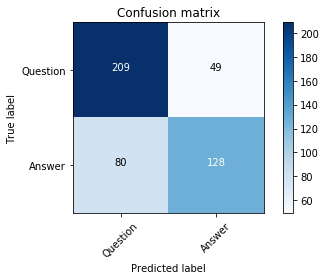

In [24]:
cnf_matrix = confusion_matrix(y_pred=y_pred, y_true=y_test)
plt.figure()
plot_confusion_matrix(
    cnf_matrix,
    title='Confusion matrix',
    classes=['Question', 'Answer']
)

In [25]:
print('Accuracy: {accuracy}'.format(accuracy=accuracy_score(y_test, y_pred)))

Accuracy: 0.723175965665236


In [26]:
print('random forrest\ntrain: {rf_train},\npredict: {rf_predict}'.format(
    rf_train=tr1-tr0,
    rf_predict=tr2-tr1
))

random forrest
train: 5.0522730350494385,
predict: 0.2880730628967285


In [13]:
## export model
if not path.exists('model'):
    makedirs('model')
joblib.dump(clf, 'model/random_forest.pkl', compress=True)

['model/random_forest.pkl']